In [2]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '449f78e7e78c4d518531c644f2872b26')

In [5]:
help(search_images_bing)

Help on function search_images_bing in module fastbook:

search_images_bing(key, term, min_sz=128, max_images=150)



In [6]:
fabrics2 = 'denim jeans','leather pants', 'linen pants'
path = Path('fabrics2')

In [7]:
if not path.exists():
    path.mkdir()
    for o in fabrics2:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}',max_images=300)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#450) [Path('fabrics2/leather pants/00000047.jpg'),Path('fabrics2/leather pants/00000012.jpeg'),Path('fabrics2/leather pants/00000063.jpeg'),Path('fabrics2/leather pants/00000139.jpeg'),Path('fabrics2/leather pants/00000091.jpeg'),Path('fabrics2/leather pants/00000021.jpeg'),Path('fabrics2/leather pants/00000061.jpeg'),Path('fabrics2/leather pants/00000097.jpg'),Path('fabrics2/leather pants/00000029.jpg'),Path('fabrics2/leather pants/00000112.jpg')...]

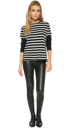

In [9]:
im = Image.open(fns[1])
im.to_thumb(128,128)

In [10]:
failed = verify_images(fns)
failed

(#4) [Path('fabrics2/leather pants/00000015.jpg'),Path('fabrics2/linen pants/00000124.jpg'),Path('fabrics2/denim jeans/00000024.jpg'),Path('fabrics2/denim jeans/00000052.jpg')]

In [11]:
failed.map(Path.unlink);

In [12]:
#Working with DataLoaders 
fabrics2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

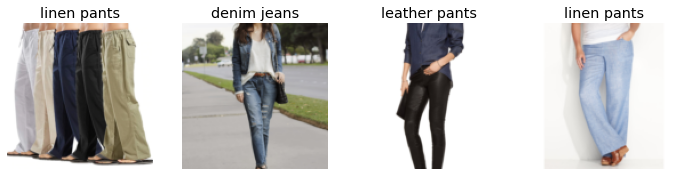

In [13]:
dls =fabrics2.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

In [14]:
fabrics2 = fabrics2.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = fabrics2.dataloaders(path)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.635855,1.483599,0.483146,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.749705,0.489175,0.168539,00:09
1,0.648586,0.243233,0.101124,00:08
2,0.543976,0.208893,0.078652,00:10


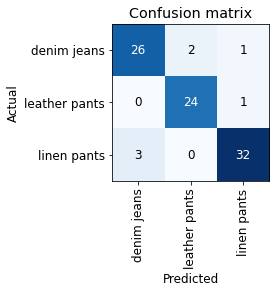

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

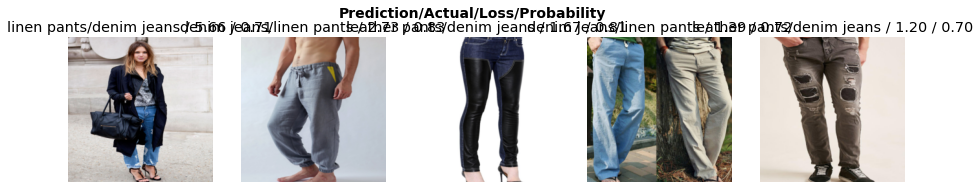

In [17]:
interp.plot_top_losses(5, nrows=1)

In [18]:
cleaner = ImageClassifierCleaner(learn)
cleaner

doc(ImageClassifierCleaner)

In [19]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()

In [20]:
for idx,cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [21]:
learn.export()

In [22]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

In [24]:
learn_inf.dls.vocab

['denim jeans', 'leather pants', 'linen pants']

In [26]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [27]:
img = PILImage.create(uploader.data[-1])

In [28]:
learn_inf.predict(img)

('denim jeans', TensorImage(0), TensorImage([0.7019, 0.2120, 0.0861]))

In [29]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()